### Pysal子模块esda《官方文档》
- Pysal项目的一个子模块（esda），专注于整体与局部的空间自相关分析

#### 柏林房价案例

In [1]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
#房价datafram转换geodataframe
gdf = gpd.read_file('example_data/berlin-neighbourhoods.geojson')
bl_df = pd.read_csv('example_data/berlin-listings.csv')
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
bl_gdf = GeoDataFrame(bl_df, crs="EPSG:4326", geometry=geometry)

In [3]:
#空间合并，房价geodataframe和矢量边界geodataframe合并
#按照neighbourhood_group分组，计算每个分组的平均房价
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()

In [ ]:
#将分组后平均房价dataseries添加到矢量边界geodataframe，对价格那一列重命名
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)

0


/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_6550/3171187470.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)


<Axes: >

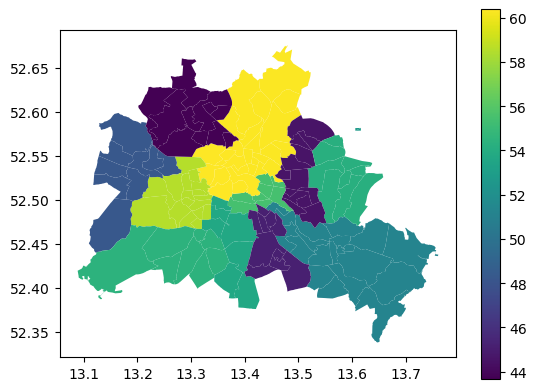

In [ ]:
#填补缺失值，绘制一个简易示意图
print(pd.isnull(gdf['median_pri']).sum())
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)
gdf.plot(column='median_pri')

<Axes: >

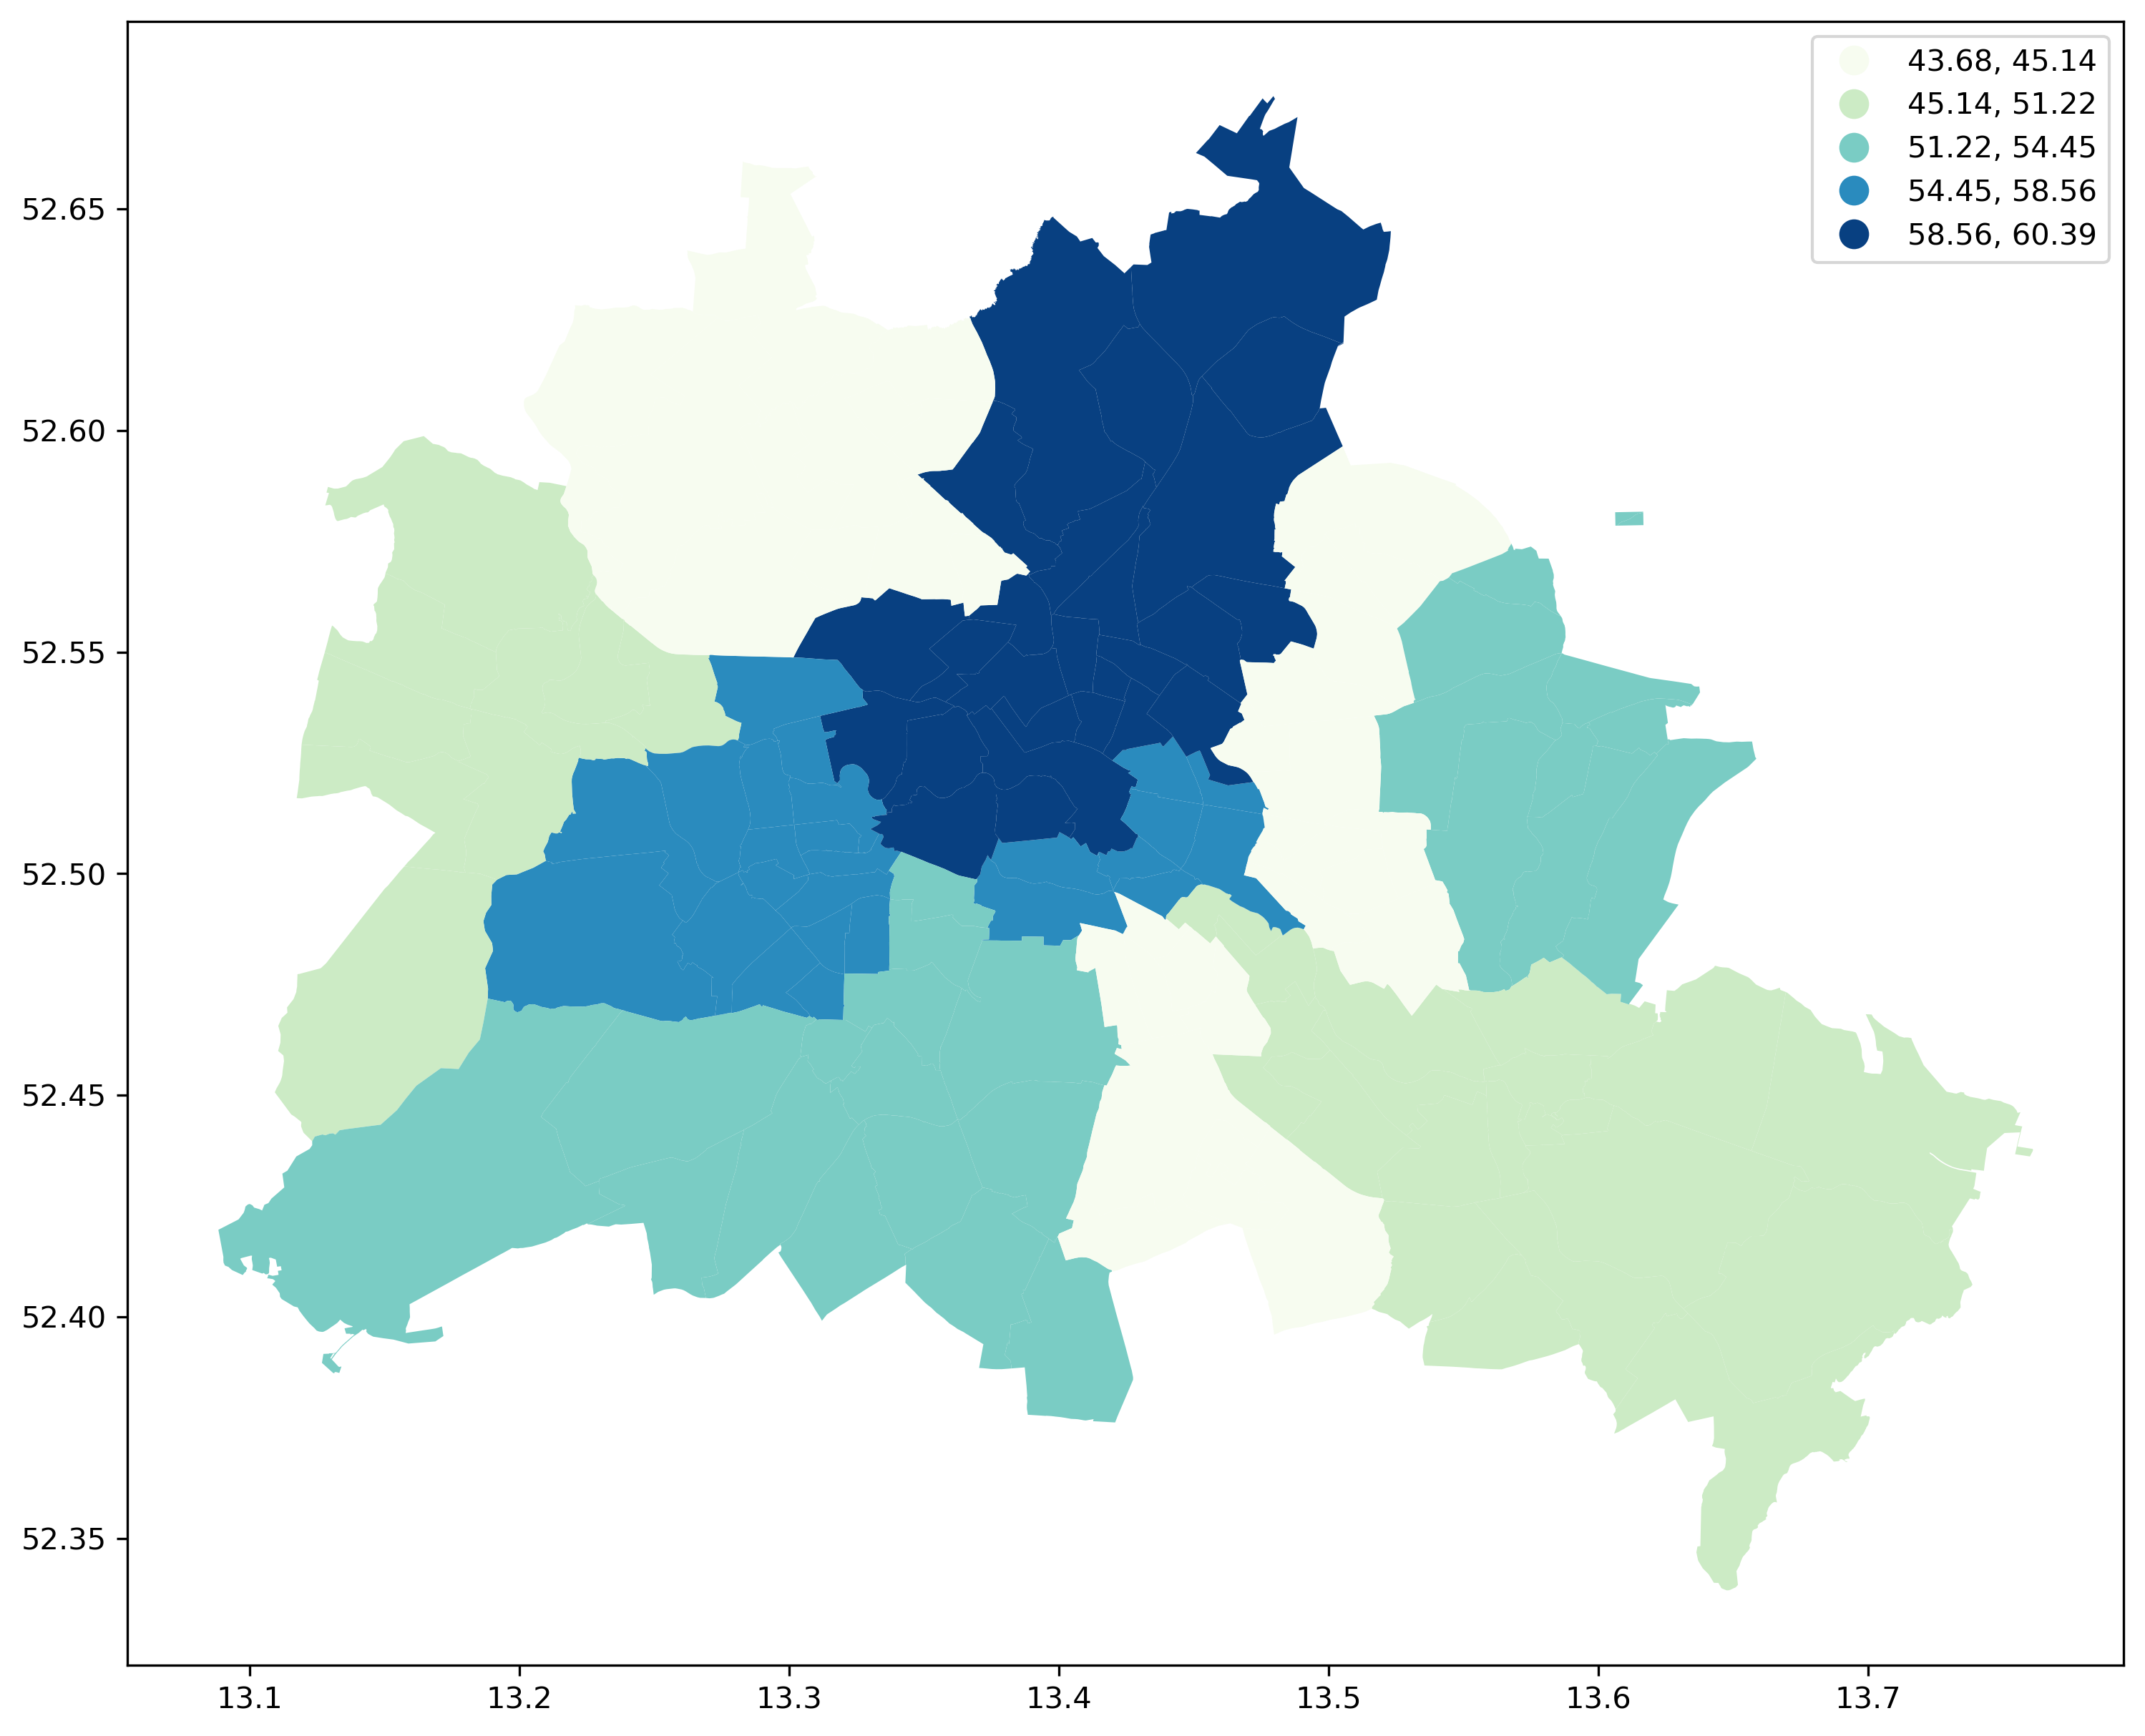

In [13]:
#美化一下这个示例图
fig, ax = plt.subplots(figsize=(12,10),dpi=300, subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

##### 前处理完成，进行空间相似性分析
1. 空间（邻接）权重
2. 属性相似度（空间滞后）

In [ ]:
#transform 属性用于指定如何转换权重矩阵的值。
# r(行标准化):将权重矩阵的每一行除以该行的权重总和，使得每一行的权重之和为1。
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/var/folders/my/kd1_1rw50f17rtwxs6h8dwk80000gn/T/ipykernel_6550/1429207122.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/Users/wangling/miniconda3/envs/geoproject/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [ ]:
#计算空间滞后
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

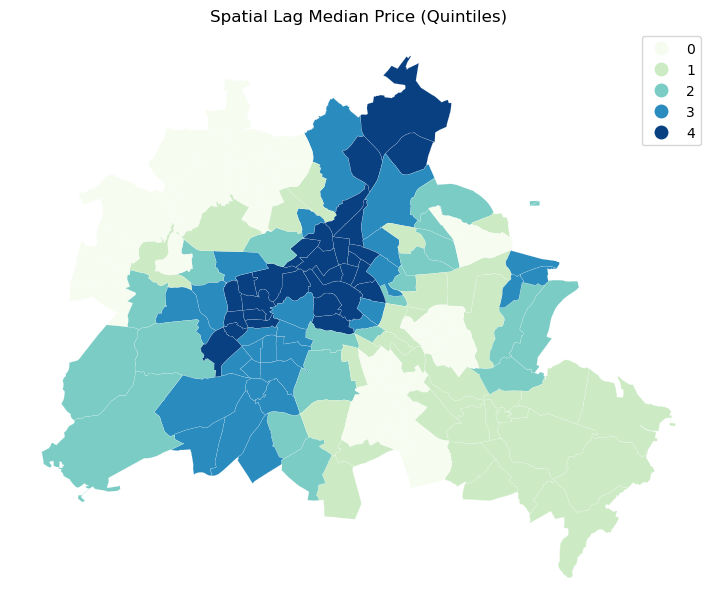

In [ ]:
#mapclassify.Quantiles()用于将空间滞后值分为五个等级，绘图
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")
plt.show()

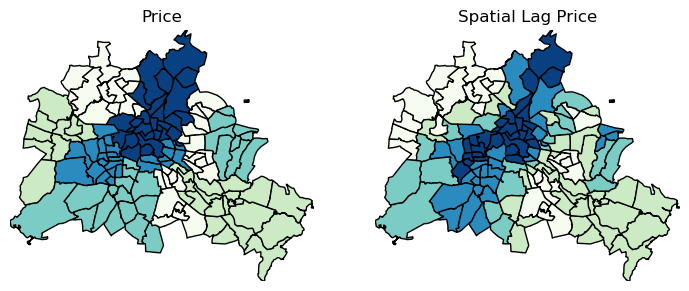

In [19]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

##### 全局空间自相关

In [20]:
y.median()

53.70440673828125